# Проект. Проверка статистических гипотез, способных помочь сервису самокатов

**Описание проекта**

Предположим, что я аналитик популярного сервиса аренды самокатов GoFast. Мне передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Мне необходимо проанализировать эти данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
* без подписки
   * абонентская плата отсутствует;
   * стоимость одной минуты поездки — 8 рублей;
   * стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra
   * абонентская плата — 199 рублей в месяц; 
   * стоимость одной минуты поездки — 6 рублей;
   * стоимость старта — бесплатно.

**Описание данных**

В основных данных есть информация о пользователях, их поездках и подписках.

Пользователи - `users`
* `user_id` - уникальный идентификатор пользователя;
* `name` - имя пользователя;
* `age` - возраст;
* `city` - город;
* `subscription_type` - тип подписки (free, ultra).

Поездки - `rides`
* `user_id` - уникальный идентификатор пользователя;
* `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах); 
* `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»; 
* `date` - дата совершения поездки.  

Подписки - subscriptions
* `subscription_type` - тип подписки;
* `minute_price` - стоимость одной минуты поездки по данной подписке;
* `start_ride_price` - стоимость начала поездки;
* `subscription_fee` - стоимость ежемесячного платежа.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

#### Шаг 1. Загрузка данных

**Считаем csv `-` файл с данными о пользователях с помощью библиотеки `pandas` и сохраним его в датафрейм `users`.**

In [2]:
users = pd.read_csv('users_go.csv')

**Выведем первые 10 строк датафрейма `users` на экран.**

In [3]:
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


**Выведем общую информацию о датафрейме `users`.**

In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


**Все типы данных в столбцах датафрейма `users` приемлемы для дальнейшей работы с ними.**

**Проверим количество пропусков в столбцах датафрейма `users`.**

In [5]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

**Пропусков в столбцах этого датафрейма нет.**

**Проверим количество строк-дубликатов в датафрейме `users`.**

In [6]:
users.duplicated().sum()

31

**В этом датафрейме есть 31 дубликат. Их необходимо будет убрать на этапе предобработки данных.**

**Проверим на сомнительные значения числовой столбец `age` таблицы `users`. Для этого выведем соответствующую гистограмму на экран.**

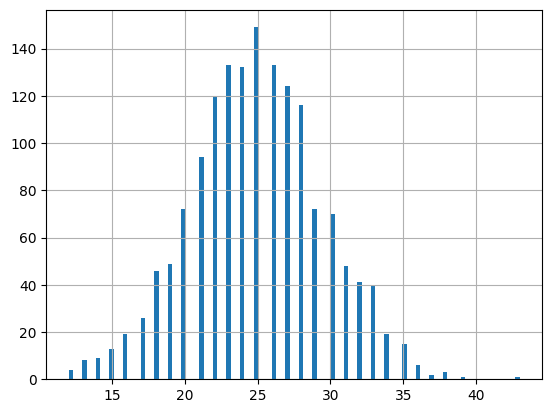

In [7]:
users['age'].hist(bins=100);

**По гистограмме видно, что возраст распределен в границах от 12 до 43 лет. Никаких аномальных значений в этом столбце нет.**

**Считаем csv `-` файл с данными о поездках с помощью библиотеки `pandas` и сохраним его в датафрейм `rides`.**

In [8]:
rides = pd.read_csv('rides_go.csv')

**Выведем первые 10 строк датафрейма `rides` на экран.**

In [9]:
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


**Выведем общую информацию о датафрейме `rides`.**

In [10]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


**Все типы данных в столбцах таблицы `rides` за исключением типа в столбце `date` приемлемы для дальнейшей работы с ними. В столбце `date` нужно заменить тип данных на `datetime` для корректной работы с датой.**

**Проверим количество пропусков в столбцах датафрейма `rides`.**

In [11]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

**Пропусков в столбцах этого датафрейма нет.**

**Проверим количество строк-дубликатов в датафрейме `rides`.**

In [12]:
rides.duplicated().sum()

0

**Строк-дубликатов в этом датафрейме нет.**

**Проверим на сомнительные значения числовые столбцы `distance` и `duration` таблицы `rides`. Для этого выведем соответствующие гистограммы на экран.**

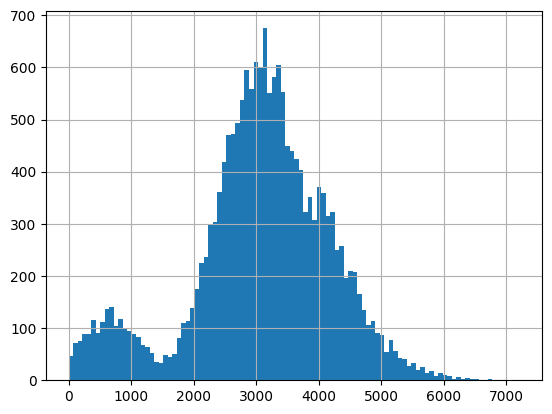

In [13]:
rides['distance'].hist(bins=100);

**Наблюдается бимодальное распределение пройденного расстояния. Сомнительных значений не видно.**

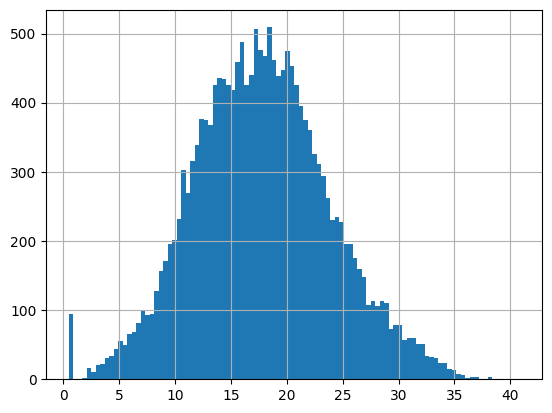

In [14]:
rides['duration'].hist(bins=100);

**Видно, что есть случаи, в которых поездки занимали крайне странное, близкое к нулю, время.**

**Считаем csv `-` файл с данными о подписках с помощью библиотеки `pandas` и сохраним его в датафрейм `subscriptions`.**

In [15]:
subscriptions = pd.read_csv('subscriptions_go.csv')

**Выведем датафрейм `subscriptions` на экран.**

In [16]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Таблица содержит информацию о типе подписки и соответствующих ценах услуг.**

#### Шаг 2. Предобработка данных

**Начнем предобработку с приведения типа данных в столбце `date` таблицы `rides` к типу `datetime`.**

In [17]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

**Проверим столбец `date` после приведения типа данных.**

In [18]:
rides['date'].head(10)

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
5   2021-10-09
6   2021-10-19
7   2021-11-06
8   2021-11-14
9   2021-11-22
Name: date, dtype: datetime64[ns]

**Тип данных успешно изменился на `datetime`. Теперь с датой из этого столбца можно работать.**

**Создадим новый столбец в таблице `rides` с номером месяца на основании столбца `date`.**

In [19]:
rides['month'] = pd.DatetimeIndex(rides['date']).month

Проверим за какой период предоставлены данные.

In [20]:
years = pd.DatetimeIndex(rides['date']).year

In [21]:
years.unique()

Int64Index([2021], dtype='int64', name='date')

В данном случае всё в порядке, все данные были предоставлены за 2021 год.

**Проверим новый столбец `month` и столбец `date` в таблице `rides` на их соответствие.**

In [22]:
rides[['date','month']].head(10)

,date,month
0,2021-01-01,1
1,2021-01-18,1
2,2021-04-20,4
3,2021-08-11,8
4,2021-08-28,8
5,2021-10-09,10
6,2021-10-19,10
7,2021-11-06,11
8,2021-11-14,11
9,2021-11-22,11


**Заметно, что номер месяца в столбце `month` соответствует номеру месяца в столбце `date`. Столбец с номером месяца добавлен и коректно отображает этот номер.**

**Рассмотрим распределение времени поездки в области очень коротких поездок.**

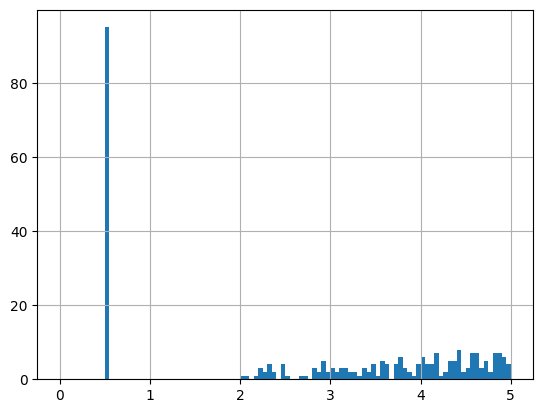

In [23]:
rides['duration'].hist(bins=100, range=(0,5));

**Поездки с длительностью меньше минуты можно исключить из рассмотрения. Скорее всего такие случаи были связаны с оплатой поездки, но не сопровождались самой поездкой (не было пройдено никакого расстояния) по тем или иным причинам. При этом алгоритм расчета времени поездки сработал таким образом, что посчитал это время как раз равным чуть меньше минуты.**

**Исключим из датафрейма `rides` строки, в столбце `duration` которых значения меньше 1 минуты.**

In [24]:
rides = rides[rides['duration'] > 1]

**Проверим, какую часть данных этого датафрейма мы в итоге отбросили.**

In [25]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17973 non-null  int64         
 1   distance  17973 non-null  float64       
 2   duration  17973 non-null  float64       
 3   date      17973 non-null  datetime64[ns]
 4   month     17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 842.5 KB


In [26]:
(1 - 17973/18067) * 100

0.5202856035866454

**Было отброшено всего 0.5% от объёма данных таблицы `rides`. Это приемлемо.**

**Рассмотрим вновь распределение длительности поездок.**

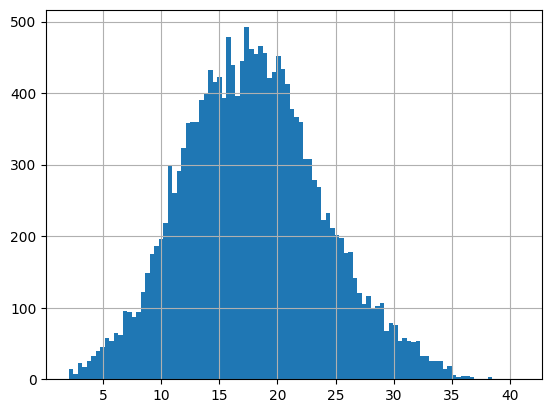

In [27]:
rides['duration'].hist(bins=100);

**Теперь распределение в порядке.**

**Вспомним, что в таблице `users` присутствовали дубликаты. Уберем их.**

In [28]:
users = users.drop_duplicates().reset_index(drop=True)

**Проверим, остались ли после этого в таблице `users` дубликаты.**

In [29]:
users.duplicated().sum()

0

**В этой таблице больше нет дубликатов.**

#### Шаг 3. Исследовательский анализ данных

**Начнем с частоты встречаемости городов. Определим сколько пользователей сервиса аренды самокатов в каждом из городов.**

In [30]:
city_data = users.pivot_table(index='city',values='user_id',aggfunc='count').sort_values(by='user_id',ascending=False)

In [31]:
city_data

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


**Для наглядности визуализируем это соответствие с помощью столбчатой диаграммы.**

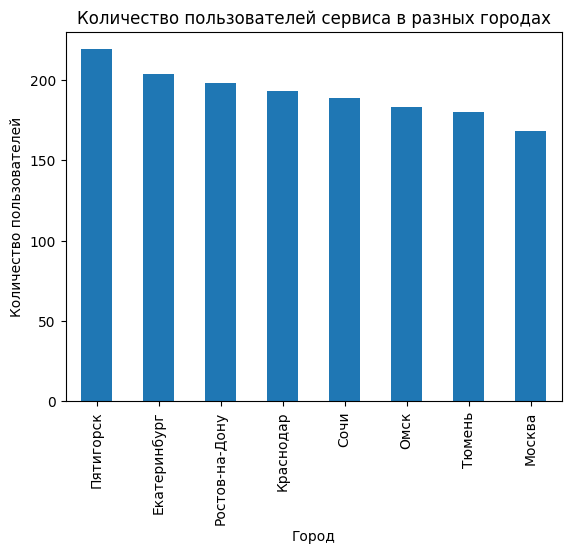

In [32]:
city_data.plot.bar(y='user_id', rot=90,title='Количество пользователей сервиса в разных городах',
                   legend=False,xlabel='Город',ylabel='Количество пользователей');

**Больше всего пользователей в Пятигорске, а меньше всего - в Москве.**

**Исследуем соотношение пользователей с подпиской и без подписки. Определим сколько пользователей имеет подписку а сколько - нет.**

In [33]:
subscription_data = users.pivot_table(index='subscription_type',values='user_id',aggfunc='count')

In [34]:
subscription_data

,user_id
subscription_type,
free,835
ultra,699


**Визуализируем это соответствие с помощью столбчатой диаграммы.**

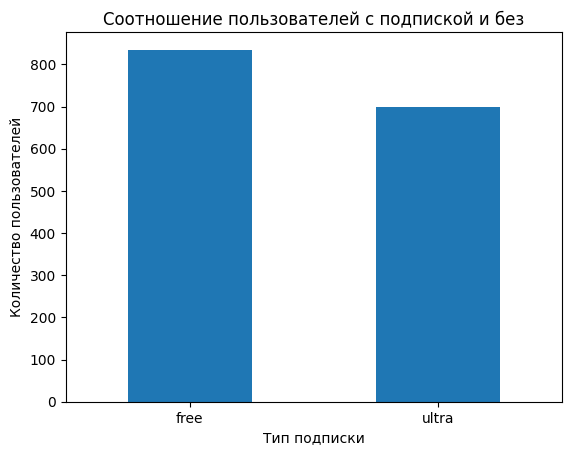

In [35]:
subscription_data.plot.bar(y='user_id', rot=0,
                           title='Соотношение пользователей с подпиской и без',legend=False,
                           ylabel='Количество пользователей',xlabel='Тип подписки');

Построим круговую диаграмму.

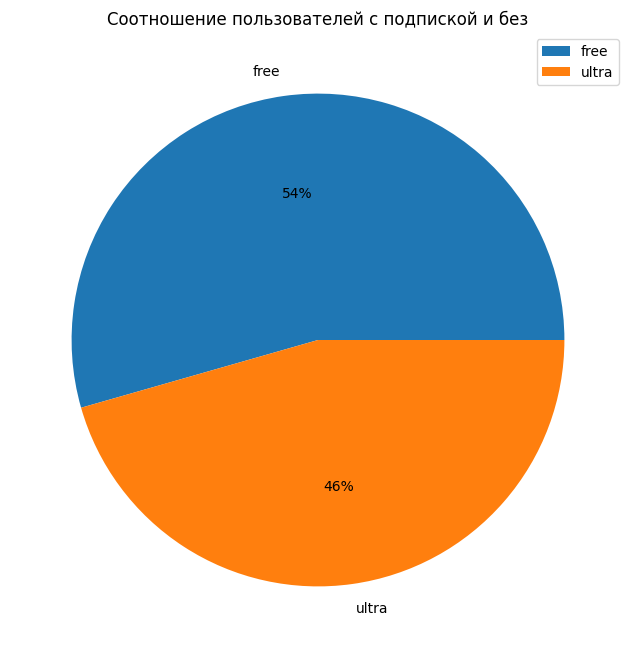

In [36]:
subscription_data.plot(y='user_id',
                       kind='pie',figsize=(8,8),
                       autopct='%1.0f%%',
                       title='Соотношение пользователей с подпиской и без',
                       ylabel='');

Пользователей без подписки больше на 8%.

**Исследуем возраст пользователей. Для этого изначально категоризируем этот параметр.**

In [37]:
def age_categorize(age):
    if age < 16:
        return 'подростки'
    if age < 25:
        return 'молодежь'
    else:
        return 'взрослые'

**Добавим новый столбец `age_group` в таблицу `users`.**

In [38]:
users['age_group'] = users['age'].apply(age_categorize)

**Теперь создадим сводную таблицу и по данным из неё построим столбчатую диаграмму.**

In [39]:
age_data = users.pivot_table(index='age_group',values='user_id',aggfunc='count')

In [40]:
age_data

,user_id
age_group,
взрослые,818
молодежь,682
подростки,34


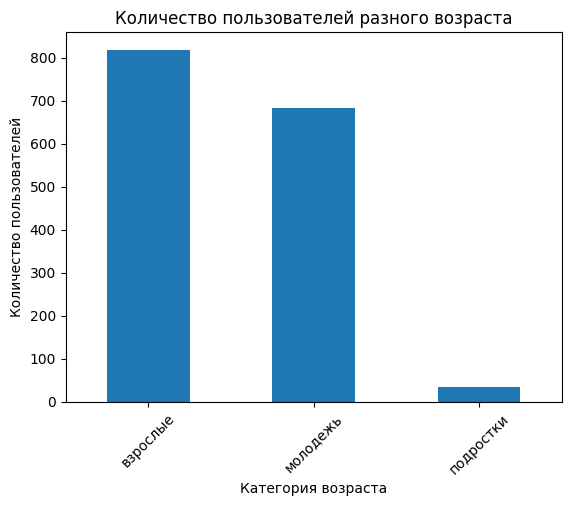

In [41]:
age_data.plot.bar(y='user_id', rot=45,legend=False,xlabel='Категория возраста',ylabel='Количество пользователей',title='Количество пользователей разного возраста');

**Взрослых пользователей сервиса больше всего. Молодежи чуть меньше, а подростков совсем мало.**

Добавлю точный возраст пользователей, которых больше всего.

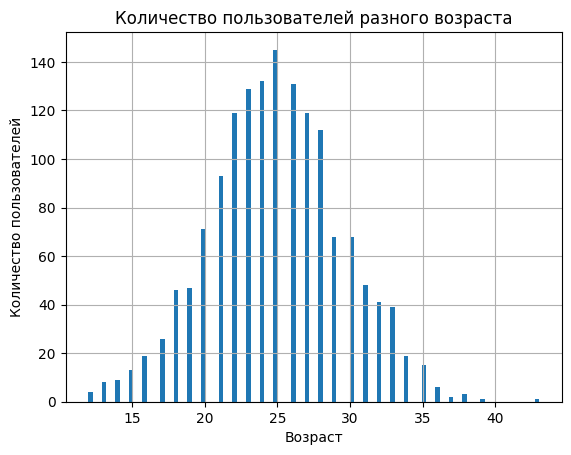

In [42]:
ax1 = users['age'].hist(bins=100)
ax1.set(xlabel='Возраст',ylabel='Количество пользователей',title='Количество пользователей разного возраста');

У сервиса больше всего пользователей, которым 25 лет.

**Исследуем расстояние, которое пользователь преодолел за одну поездку. Для этого снова понадобится категоризация.**

In [43]:
def distance_categorize(distance):
    if distance < 2000:
        return 'меньше 2 км'
    if distance < 4000:
        return 'от 2 до 4 км'
    if distance < 6000:
        return 'от 4 до 6 км'
    else:
        return 'от 6 км и больше'

**Добавим новый столбец `distance_group` в таблицу `rides`.**

In [44]:
rides['distance_group'] = rides['distance'].apply(distance_categorize)

**Cоздадим сводную таблицу и по данным из неё построим столбчатую диаграмму.**

In [45]:
distance_data = rides.pivot_table(index='distance_group',values='user_id',aggfunc='count')

In [46]:
distance_data

,user_id
distance_group,
меньше 2 км,2352
от 2 до 4 км,12238
от 4 до 6 км,3347
от 6 км и больше,36


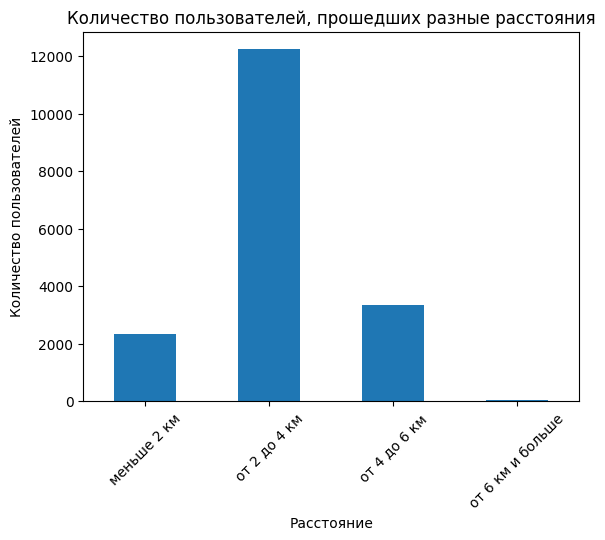

In [47]:
distance_data.plot.bar(y='user_id', rot=45,legend=False,xlabel='Расстояние',ylabel='Количество пользователей',title='Количество пользователей, прошедших разные расстояния');

**Больше всего пользователей преодолели за одну поездку от 2 до 4 километров. Примерно одинаковые части пользователей приодолели меньше 2 километров и от 4 до 6 километров. Более 6 километров преодолели единицы пользователей.**

**Исследуем продолжительности поездок пользователей. Вновь понадобится категоризация.**

In [48]:
def duration_categorize(duration):
    if duration < 10:
        return 'меньше 10 мин'
    if duration < 20:
        return 'от 10 до 20 мин'
    if duration < 30:
        return 'от 20 до 30 мин'
    else:
        return 'от 30 мин и более'

**Добавим новый столбец `duration_group` в таблицу `rides`.**

In [49]:
rides['duration_group'] = rides['duration'].apply(duration_categorize)

**Cоздадим сводную таблицу и по данным из неё построим столбчатую диаграмму.**

In [50]:
duration_data = rides.pivot_table(index='duration_group',values='user_id',aggfunc='count')

In [51]:
duration_data

,user_id
duration_group,
меньше 10 мин,1544
от 10 до 20 мин,10095
от 20 до 30 мин,5791
от 30 мин и более,543


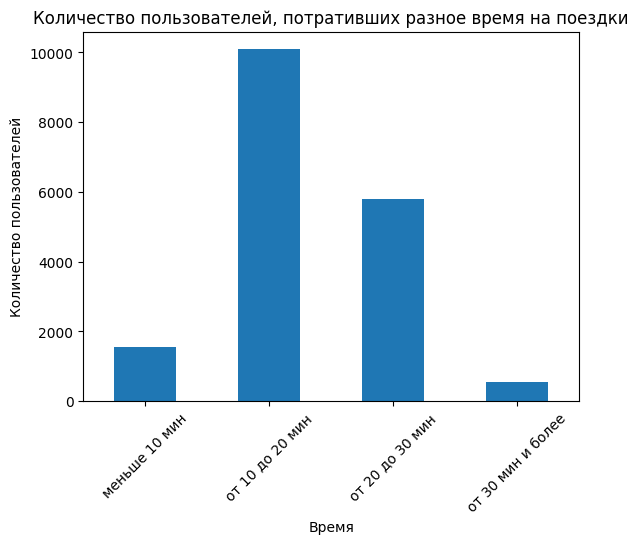

In [52]:
duration_data.plot.bar(y='user_id', rot=45,title='Количество пользователей, потративших разное время на поездки',legend=False,xlabel='Время',ylabel='Количество пользователей');

**Продолжительность поездки пользователей сервиса чаще всего оказывается в пределах от 10 до 20 минут. Нередки случаи и с поездками по 20 - 30 минут. А вот поездки меньше 10 минут и более получаса редкие.**

#### Шаг 4. Объединение данных

**Сперва объединим таблицы `users` и `rides` по столбцу `user_id`.**

In [53]:
users_rides = users.merge(rides, on='user_id', how='left')

**Посмотрим на результат.**

In [54]:
users_rides.head(10)

,user_id,name,age,city,subscription_type,age_group,distance,duration,date,month,distance_group,duration_group
0,1,Кира,22,Тюмень,ultra,молодежь,4409.919140,25.599769,2021-01-01,1,от 4 до 6 км,от 20 до 30 мин
1,1,Кира,22,Тюмень,ultra,молодежь,2617.592153,15.816871,2021-01-18,1,от 2 до 4 км,от 10 до 20 мин
2,1,Кира,22,Тюмень,ultra,молодежь,754.159807,6.232113,2021-04-20,4,меньше 2 км,меньше 10 мин
3,1,Кира,22,Тюмень,ultra,молодежь,2694.783254,18.511000,2021-08-11,8,от 2 до 4 км,от 10 до 20 мин
4,1,Кира,22,Тюмень,ultra,молодежь,4028.687306,26.265803,2021-08-28,8,от 4 до 6 км,от 20 до 30 мин
5,1,Кира,22,Тюмень,ultra,молодежь,2770.890808,16.650138,2021-10-09,10,от 2 до 4 км,от 10 до 20 мин
6,1,Кира,22,Тюмень,ultra,молодежь,3039.020292,14.927879,2021-10-19,10,от 2 до 4 км,от 10 до 20 мин
7,1,Кира,22,Тюмень,ultra,молодежь,2842.118050,23.117468,2021-11-06,11,от 2 до 4 км,от 20 до 30 мин
8,1,Кира,22,Тюмень,ultra,молодежь,3412.690668,15.238072,2021-11-14,11,от 2 до 4 км,от 10 до 20 мин
9,1,Кира,22,Тюмень,ultra,молодежь,748.690645,15.041884,2021-11-22,11,меньше 2 км,от 10 до 20 мин


**Результат удовлетворительный.**

**Теперь объединим таблицы `users_rides` и `subscriptions` по столбцу `subscription_type`.**

In [55]:
data_final = users_rides.merge(subscriptions, on='subscription_type', how='left')

**Посмотрим на результат.**

In [56]:
data_final.head(10)

,user_id,name,age,city,subscription_type,age_group,distance,duration,date,month,distance_group,duration_group,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,молодежь,4409.919140,25.599769,2021-01-01,1,от 4 до 6 км,от 20 до 30 мин,6,0,199
1,1,Кира,22,Тюмень,ultra,молодежь,2617.592153,15.816871,2021-01-18,1,от 2 до 4 км,от 10 до 20 мин,6,0,199
2,1,Кира,22,Тюмень,ultra,молодежь,754.159807,6.232113,2021-04-20,4,меньше 2 км,меньше 10 мин,6,0,199
3,1,Кира,22,Тюмень,ultra,молодежь,2694.783254,18.511000,2021-08-11,8,от 2 до 4 км,от 10 до 20 мин,6,0,199
4,1,Кира,22,Тюмень,ultra,молодежь,4028.687306,26.265803,2021-08-28,8,от 4 до 6 км,от 20 до 30 мин,6,0,199
5,1,Кира,22,Тюмень,ultra,молодежь,2770.890808,16.650138,2021-10-09,10,от 2 до 4 км,от 10 до 20 мин,6,0,199
6,1,Кира,22,Тюмень,ultra,молодежь,3039.020292,14.927879,2021-10-19,10,от 2 до 4 км,от 10 до 20 мин,6,0,199
7,1,Кира,22,Тюмень,ultra,молодежь,2842.118050,23.117468,2021-11-06,11,от 2 до 4 км,от 20 до 30 мин,6,0,199
8,1,Кира,22,Тюмень,ultra,молодежь,3412.690668,15.238072,2021-11-14,11,от 2 до 4 км,от 10 до 20 мин,6,0,199
9,1,Кира,22,Тюмень,ultra,молодежь,748.690645,15.041884,2021-11-22,11,меньше 2 км,от 10 до 20 мин,6,0,199


**Таблицы объединились корректно.**

Проверим, все ли строки вошли в получившийся датафрейм.

In [57]:
print(data_final.shape,rides.shape)

(17973, 15) (17973, 7)


Все 17973 строки вошли в получившийся датафрейм.

**Создадим таблицу с данными о пользователях без подписки на основании таблицы `data_final`.**

In [58]:
df_free = data_final[data_final['subscription_type']=='free']

**Проверим полученную таблицу.**

In [59]:
df_free.head(10)

,user_id,name,age,city,subscription_type,age_group,distance,duration,date,month,distance_group,duration_group,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,молодежь,2515.690719,14.944286,2021-01-02,1,от 2 до 4 км,от 10 до 20 мин,8,50,0
6501,700,Айдар,22,Омск,free,молодежь,846.932642,16.234663,2021-02-01,2,меньше 2 км,от 10 до 20 мин,8,50,0
6502,700,Айдар,22,Омск,free,молодежь,4004.434142,20.016628,2021-02-04,2,от 4 до 6 км,от 20 до 30 мин,8,50,0
6503,700,Айдар,22,Омск,free,молодежь,1205.911290,9.782872,2021-02-10,2,меньше 2 км,меньше 10 мин,8,50,0
6504,700,Айдар,22,Омск,free,молодежь,3047.379435,17.427673,2021-02-14,2,от 2 до 4 км,от 10 до 20 мин,8,50,0
6505,700,Айдар,22,Омск,free,молодежь,4342.002254,22.368009,2021-02-23,2,от 4 до 6 км,от 20 до 30 мин,8,50,0
6506,700,Айдар,22,Омск,free,молодежь,3798.334905,18.243756,2021-03-03,3,от 2 до 4 км,от 10 до 20 мин,8,50,0
6507,700,Айдар,22,Омск,free,молодежь,2984.551206,15.424899,2021-04-09,4,от 2 до 4 км,от 10 до 20 мин,8,50,0
6508,700,Айдар,22,Омск,free,молодежь,3360.107141,16.765497,2021-06-12,6,от 2 до 4 км,от 10 до 20 мин,8,50,0
6509,700,Айдар,22,Омск,free,молодежь,2567.543847,11.312160,2021-06-23,6,от 2 до 4 км,от 10 до 20 мин,8,50,0


**Таблица создана верно.**

**Создадим таблицу с данными о пользователях с подпиской на основании таблицы `data_final`.**

In [60]:
df_ultra = data_final[data_final['subscription_type']=='ultra']

**Проверим полученную таблицу.**

In [61]:
df_ultra.head(10)

,user_id,name,age,city,subscription_type,age_group,distance,duration,date,month,distance_group,duration_group,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,молодежь,4409.919140,25.599769,2021-01-01,1,от 4 до 6 км,от 20 до 30 мин,6,0,199
1,1,Кира,22,Тюмень,ultra,молодежь,2617.592153,15.816871,2021-01-18,1,от 2 до 4 км,от 10 до 20 мин,6,0,199
2,1,Кира,22,Тюмень,ultra,молодежь,754.159807,6.232113,2021-04-20,4,меньше 2 км,меньше 10 мин,6,0,199
3,1,Кира,22,Тюмень,ultra,молодежь,2694.783254,18.511000,2021-08-11,8,от 2 до 4 км,от 10 до 20 мин,6,0,199
4,1,Кира,22,Тюмень,ultra,молодежь,4028.687306,26.265803,2021-08-28,8,от 4 до 6 км,от 20 до 30 мин,6,0,199
5,1,Кира,22,Тюмень,ultra,молодежь,2770.890808,16.650138,2021-10-09,10,от 2 до 4 км,от 10 до 20 мин,6,0,199
6,1,Кира,22,Тюмень,ultra,молодежь,3039.020292,14.927879,2021-10-19,10,от 2 до 4 км,от 10 до 20 мин,6,0,199
7,1,Кира,22,Тюмень,ultra,молодежь,2842.118050,23.117468,2021-11-06,11,от 2 до 4 км,от 20 до 30 мин,6,0,199
8,1,Кира,22,Тюмень,ultra,молодежь,3412.690668,15.238072,2021-11-14,11,от 2 до 4 км,от 10 до 20 мин,6,0,199
9,1,Кира,22,Тюмень,ultra,молодежь,748.690645,15.041884,2021-11-22,11,меньше 2 км,от 10 до 20 мин,6,0,199


**Таблица создана верно.**

**Визуализируем информацию о расстоянии и времени поездок для пользователей двух категорий. Для этого создадим соответствующие сводные таблицы.**

In [62]:
distance_data_free = df_free.pivot_table(index='user_id',values='distance',aggfunc='mean')

In [63]:
distance_data_ultra = df_ultra.pivot_table(index='user_id',values='distance',aggfunc='mean')

In [64]:
duration_data_free = df_free.pivot_table(index='user_id',values='duration',aggfunc='mean')

In [65]:
duration_data_ultra = df_ultra.pivot_table(index='user_id',values='duration',aggfunc='mean')

**Теперь построим соответствующие распределения для расстояний и длительностей поездок для двух категорий подписок.**

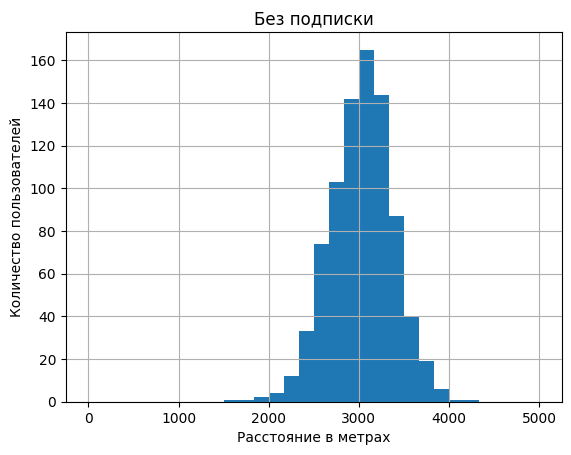

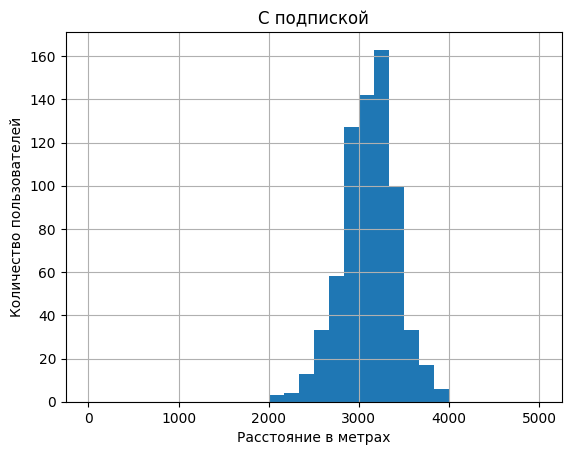

In [66]:
ax2 = distance_data_free['distance'].hist(bins=30,range=(0,5000));
ax2.set(xlabel='Расстояние в метрах',ylabel='Количество пользователей',title='Без подписки');
plt.show()
ax3 = distance_data_ultra['distance'].hist(bins=30,range=(0,5000));
ax3.set(xlabel='Расстояние в метрах',ylabel='Количество пользователей',title='C подпиской');
plt.show()

**Заметно, что наиболее частое значение пройденного расстояния пользователями с подпиской чуть выше анологичного расстояния для пользователей без неё.**

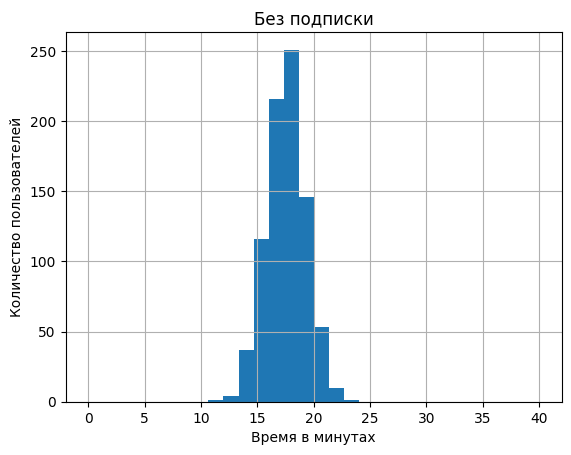

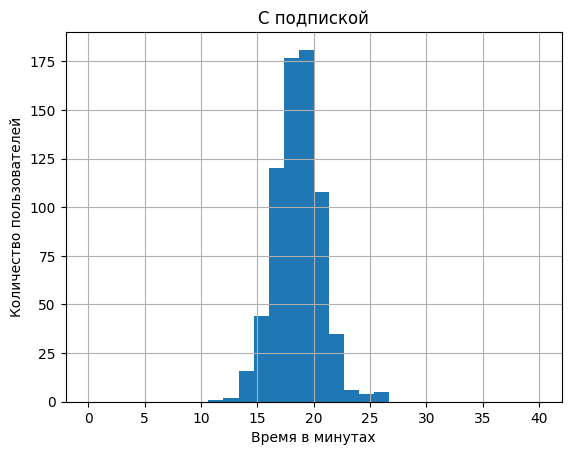

In [67]:
ax4 = duration_data_free['duration'].hist(bins=30,range=(0,40));
ax4.set(xlabel='Время в минутах',ylabel='Количество пользователей',title='Без подписки');
plt.show()
ax5 = duration_data_ultra['duration'].hist(bins=30,range=(0,40));
ax5.set(xlabel='Время в минутах',ylabel='Количество пользователей',title='С подпиской');
plt.show()

**Видно, что наиболее частое значение продолжительности поездки у пользователей с подпиской чуть выше анологичной продолжительности у пользователей без подписки.**

#### Шаг 5. Подсчёт выручки

**Создадим датафрейм `aggregate_table` с агрегированными данными о поездках на основе датафрейма с объединёнными данными `data_final`: найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.**

In [68]:
total_distance_array = [] # список для хранения данных о суммарном расстоянии
total_rides_array = [] # список для хранения данных о количестве поездок
total_duration_array = [] # список для хранения данных о суммарном времени поездок
id_array = [] # список для хранения данных о индексах пользователей
month_array_12 = [1,2,3,4,5,6,7,8,9,10,11,12] # список месяцев
month_array = month_array_12 * data_final['user_id'].nunique() # список месяцев для всех индексов пользователей

for id in data_final['user_id'].unique(): # для каждого уникального индекса пользователя
    for month_number in range(1,13): # для каждого из 12 месяцев года
        try: # случай, когда за месяц происходили поездки
            total_distance = data_final[(data_final['user_id']==id)&(data_final['month']==month_number)]['distance'].sum()
            total_rides = data_final[(data_final['user_id']==id)&(data_final['month']==month_number)]['user_id'].count()
            total_duration = data_final[(data_final['user_id']==id)&(data_final['month']==month_number)]['duration'].sum()
            total_distance_array.append(total_distance)
            total_rides_array.append(total_rides)
            total_duration_array.append(total_duration)
            id_array.append(id)
        except: # случай, когда за месяц не было поездок
            total_distance = 0
            total_rides = 0
            total_duration = 0
            total_distance_array.append(total_distance)
            total_rides_array.append(total_rides)
            total_duration_array.append(total_duration)
            id_array.append(id)

In [69]:
aggregate_table = pd.DataFrame({'month':month_array,'user_id':id_array,'total_distance':total_distance_array,'total_rides':total_rides_array,'total_duration':total_duration_array})

**Рассмотрим созданный датафрейм и проверим его содержимое.**

In [70]:
aggregate_table.head(10)

,month,user_id,total_distance,total_rides,total_duration
0,1,1,7027.511294,2,41.416640
1,2,1,0.000000,0,0.000000
2,3,1,0.000000,0,0.000000
3,4,1,754.159807,1,6.232113
4,5,1,0.000000,0,0.000000
5,6,1,0.000000,0,0.000000
6,7,1,0.000000,0,0.000000
7,8,1,6723.470560,2,44.776802
8,9,1,0.000000,0,0.000000
9,10,1,5809.911100,2,31.578017


**Датафрейм `aggregate_table` правильно описывает необходимые метрики для каждого пользователя за каждый месяц.**

**Рассчитаем помесячную выручку и добавим эту метрику в новый столбец в таблицу `aggregate_table`.**

**Сперва округлим в большую сторону все значения в столбце `total_duration` таблицы `aggregate_table`.**

In [71]:
aggregate_table['total_duration'] = np.ceil(aggregate_table['total_duration'])

**Уберем из датафрейма `aggregate_table` неинформативные строки.**

In [72]:
aggregate_table = aggregate_table[aggregate_table['total_rides'] != 0]

**Приведём индексы в порядок.**

In [73]:
aggregate_table = aggregate_table.reset_index(drop=True)

**Посмотрим на полученную таблицу.**

In [74]:
aggregate_table.head(10)

,month,user_id,total_distance,total_rides,total_duration
0,1,1,7027.511294,2,42.0
1,4,1,754.159807,1,7.0
2,8,1,6723.470560,2,45.0
3,10,1,5809.911100,2,32.0
4,11,1,7003.499363,3,54.0
5,12,1,6751.629942,2,28.0
6,3,2,10187.723006,3,61.0
7,4,2,6164.381824,2,40.0
8,6,2,3255.338202,1,14.0
9,7,2,6780.722964,2,47.0


**Индексы идут по порядку, значения в столбце `total_duration` округлены в большую сторону, неинформативные строки убраны.**

**Перед расчётом помесячной выручки добавим в таблицу `aggregate_table` все необходимые столбцы.**

In [75]:
aggregate_table_2 = aggregate_table.merge(users, on='user_id', how='left')
aggregate_table_2 = aggregate_table_2.drop(columns=['name','age','city','age_group'])
aggregate_table_3 = aggregate_table_2.merge(subscriptions, on ='subscription_type', how='left')

In [76]:
aggregate_table_3.head(10)

,month,user_id,total_distance,total_rides,total_duration,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,2,42.0,ultra,6,0,199
1,4,1,754.159807,1,7.0,ultra,6,0,199
2,8,1,6723.470560,2,45.0,ultra,6,0,199
3,10,1,5809.911100,2,32.0,ultra,6,0,199
4,11,1,7003.499363,3,54.0,ultra,6,0,199
5,12,1,6751.629942,2,28.0,ultra,6,0,199
6,3,2,10187.723006,3,61.0,ultra,6,0,199
7,4,2,6164.381824,2,40.0,ultra,6,0,199
8,6,2,3255.338202,1,14.0,ultra,6,0,199
9,7,2,6780.722964,2,47.0,ultra,6,0,199


**Теперь рассчитаем помесячную выручку и добавим в таблицу `aggregate_table_3` соответствующий столбец.**

In [77]:
aggregate_table_3['price_per_month'] = aggregate_table_3['minute_price']*aggregate_table_3['total_duration'] + aggregate_table_3['start_ride_price']*aggregate_table_3['total_rides'] + aggregate_table_3['subscription_fee']

**Проверим, добавился ли новый столбец и что в нём отобразилось.**

In [78]:
aggregate_table_3.head(10)

,month,user_id,total_distance,total_rides,total_duration,subscription_type,minute_price,start_ride_price,subscription_fee,price_per_month
0,1,1,7027.511294,2,42.0,ultra,6,0,199,451.0
1,4,1,754.159807,1,7.0,ultra,6,0,199,241.0
2,8,1,6723.470560,2,45.0,ultra,6,0,199,469.0
3,10,1,5809.911100,2,32.0,ultra,6,0,199,391.0
4,11,1,7003.499363,3,54.0,ultra,6,0,199,523.0
5,12,1,6751.629942,2,28.0,ultra,6,0,199,367.0
6,3,2,10187.723006,3,61.0,ultra,6,0,199,565.0
7,4,2,6164.381824,2,40.0,ultra,6,0,199,439.0
8,6,2,3255.338202,1,14.0,ultra,6,0,199,283.0
9,7,2,6780.722964,2,47.0,ultra,6,0,199,481.0


**Столбец добавлен, значения в нём корректные.**

**Теперь уберём лишние столбцы из датафрейма `aggregate_table_3`.**

In [79]:
aggregate_table_3 = aggregate_table_3.drop(columns=['minute_price','start_ride_price','subscription_fee'])

**Выведем первые 30 строк обработанного датафрейма `aggregate_table_3` на экран.**

In [80]:
aggregate_table_3.head(10)

,month,user_id,total_distance,total_rides,total_duration,subscription_type,price_per_month
0,1,1,7027.511294,2,42.0,ultra,451.0
1,4,1,754.159807,1,7.0,ultra,241.0
2,8,1,6723.470560,2,45.0,ultra,469.0
3,10,1,5809.911100,2,32.0,ultra,391.0
4,11,1,7003.499363,3,54.0,ultra,523.0
5,12,1,6751.629942,2,28.0,ultra,367.0
6,3,2,10187.723006,3,61.0,ultra,565.0
7,4,2,6164.381824,2,40.0,ultra,439.0
8,6,2,3255.338202,1,14.0,ultra,283.0
9,7,2,6780.722964,2,47.0,ultra,481.0


#### Шаг 6. Проверка гипотез

**Проверим, тратят ли пользователи с подпиской больше времени на поездки.**

**Сформулируем нулевую и альтернативную гипотезы.**

**Нулевая гипотеза: средние значения времени поездки пользователей с подпиской и без равны.**

**Альтернативная гипотеза: среднее значение времени поездки пользователей с подпиской больше среднего значения времени поездки пользователей без подписки.**

**Проверим гипотезы.**

In [81]:
alpha = 0.05 

duration_free = duration_data_free['duration']
duration_ultra = duration_data_ultra['duration']

result = st.ttest_ind(duration_ultra,duration_free,alternative='greater')

print(f'p-значение: {result.pvalue}')

if result.pvalue < alpha:
    print('отвергаем нулевую гипотезу в сторону альтернативной')
else:
    print('нет оснований отвергнуть нулевую гипотезу')


p-значение: 1.664581641646187e-27
отвергаем нулевую гипотезу в сторону альтернативной


**Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки.**

**Проверим, не превышает ли 3130 метров расстояние, которое проезжают пользователи с подпиской за одну поездку.**

**Сформулируем нулевую и альтернативную гипотезы.**

**Нулевая гипотеза: среднее значение расстояния, которое проезжают пользователи равно 3130 метров.**

**Альтернативная гипотеза: среднее значение расстояния, которое проезжают пользователи больше 3130 метров.**

**Проверим гипотезы.**

In [82]:
alpha = 0.05

distance_ultra = distance_data_ultra['distance']

mean_distance = 3130

result = st.ttest_1samp(distance_ultra,mean_distance,alternative='greater')

print(f'p-значение: {result.pvalue}')

if result.pvalue < alpha:
    print('отвергаем нулевую гипотезу в сторону альтернативной')
else:
    print('нет оснований отвергнуть нулевую гипотезу')

p-значение: 0.9275041260050892
нет оснований отвергнуть нулевую гипотезу


**Есть основания говорить, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.**

**Проверим, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.**

**Сформулируем нулевую и альтернативную гипотезы.**

**Нулевая гипотеза: средние значения помесячной выручки пользователей с подпиской и без равны.**

**Альтернативная гипотеза: среднее значение помесячной выручки пользователей с подпиской больше среднего значения помесячной выручки пользователей без подписки.**

**Проверим гипотезы.**

In [83]:
alpha = 0.05 

month_income_free = aggregate_table_3[aggregate_table_3['subscription_type']=='free']['price_per_month']
month_income_ultra = aggregate_table_3[aggregate_table_3['subscription_type']=='ultra']['price_per_month']

result = st.ttest_ind(month_income_ultra,month_income_free,alternative='greater')

print(f'p-значение: {result.pvalue}')

if result.pvalue < alpha:
    print('отвергаем нулевую гипотезу в сторону альтернативной')
else:
    print('нет оснований отвергнуть нулевую гипотезу')


p-значение: 3.914474385320123e-34
отвергаем нулевую гипотезу в сторону альтернативной


**Есть основания говорить, что пользователи с подпиской тратят больше денег в месяц на поездки. Соответственно сервису нужно стремится к тому, чтобы пользователи покупали подписку чаще.**

**Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.**

**Эта гипотеза относится к гипотезам о равенстве средних для зависимых (парных) выборок. Для проверки этой гипотезы понадобился бы тест `st.ttest_rel` из библиотеки `scipy.stats`.**

#### Общий вывод

В результате исследования были получены следующие результаты:
* больше всего пользователей в Пятигорске, а меньше всего - в Москве
* пользователей без подписки больше на 8%
* взрослых пользователей сервиса больше всего. Молодежи чуть меньше, а подростков совсем мало. Больше всего пользователей, которым 25 лет
* больше всего пользователей преодолели за одну поездку от 2 до 4 километров. Примерно одинаковые части пользователей приодолели меньше 2 километров и от 4 до 6 километров. Более 6 километров преодолели единицы пользователей
* продолжительность поездки пользователей сервиса чаще всего оказывается в пределах от 10 до 20 минут. Нередки случаи и с поездками по 20 - 30 минут. А вот поездки меньше 10 минут и более получаса редкие

* пользователи с подпиской могут быть "выгоднее" для компании, так как есть основания говорить, что они тратят больше времени на поездки
* скорее всего самокаты не будут изношены, так как есть основания говорить, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров
* сервису нужно стремится к тому, чтобы пользователи покупали подписку чаще, так как есть основания говорить, что такие пользователи тратят больше денег в месяц на поездки